In [1]:
%load_ext autoreload
%load_ext autotime
%autoreload 2

import numpy as np
import torch
import matplotlib.pyplot as plt
from CuSP import MEInversion, MEForward

time: 1.48 s (started: 2025-04-25 06:24:01 +08:00)


In [2]:
help(MEInversion) # help information of the inversion module

Help on class MEInversion in module CuSP.me_inversion:

class MEInversion(CuSP.me_forward.MEForward)
 |  MEInversion(wavebands, landeG=2.5, lambda0=630.25, wing=None)
 |
 |  Method resolution order:
 |      MEInversion
 |      CuSP.me_forward.MEForward
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __call__(self, iquv_obs: torch.Tensor, **kwargs)
 |      Input:
 |          iquv_obs: torch.Tensor, observed IQUV with shape (B,4,N)
 |      ====
 |      Parameters:
 |          method: str, optimization method, default: 'gsa', ['gsa','csa']
 |          device: torch.device, device, default: iquv_obs.device
 |          Other parameters see `CudaAnnealing` if 'csa' or `DualAnnealing` if 'gsa'
 |      ====
 |      Output:
 |          params_ivs: torch.Tensor, inverted parameters
 |
 |  __init__(self, wavebands, landeG=2.5, lambda0=630.25, wing=None)
 |      Initialize the MEForward class
 |      Input:
 |          waveband  [nm]  -> waveband of interest
 |          landeG    []   

In [3]:
"""
Setup the forward model and inverison model.
Generating the `nums` set of params (params_obs) and the corresponding iquv profile (`iquv_obs`)
Which simulate the instrument's obsevation profile
"""
lambda0 = 630.25 # nm
dlambda = 4e-4   # nm
nlambda = 100    # sample numbers
ll      = lambda0-0.5*dlambda*nlambda+np.arange(nlambda)*dlambda
lm = np.linspace(lambda0-50e-4*0.5*5,lambda0+50e-4*0.5*5,7)
ll_tensor = torch.from_numpy(ll).float().cuda()
lm_tensor = torch.from_numpy(lm).float().cuda()

forward   = MEForward(lm_tensor,lambda0=630.25,landeG=2.5,wing=ll.min())
inversion = MEInversion(lm_tensor,lambda0=630.25,landeG=2.5,wing=ll.min())

nums = 100
x_obs = torch.rand(nums,8).cuda()
params_obs = inversion.denormalizing_parameter(x_obs)
iquv_obs = torch.stack(list(forward(*params_obs.T[:,:,None])),dim=1)

time: 471 ms (started: 2025-04-25 06:31:01 +08:00)


In [10]:
"""
Do the inversion parallelly based on the Cuda Device
Paramters:
Two types of methods is optional: 'csa' and 'gsa', corresponding to the new and old version.
When method='gsa' (default), the new version (Generalized Simulated Annealing) is used (recommended).
    Parameters:
        bounds: iterable
            The bounds of the parameters. 
            (not recommended to change, because we do the normalization before the inversion)
        args: tuple, list, array_like
            The arguments of the objective function.
        maxiter: int
            The maximum number of iterations.
        adam: dict
            The arguments of the Adam optimizer.
            keys: learning_rate, betas, eps, max_batches, gamma, decay_step
        initial_temp: float
            The initial temperature. Default value is 5230.
        visit: float
            The visiting parameter to control the visiting distribution. Default value is 2.62.
        accept: float
            The acceptance parameter to control the acceptance probability. Default value is -5.0.
        no_local_search: bool
            Whether to perform local search. Default value is False.
        x0: tensor_like
            The initial guess of the parameters. Default value is None.
When method='csa', the old version (Conjugate Simulated Annealing) is used.
    Parameters:
        initial_temperature: float
        accept: float
        accept_ratio: float
        ds_min: float
        initial_stepsize: float
        patience: int
        cooling_rate: float
        max_iter: int
        preference_rate: float
        ending_temperature: float
        step_type: str
        adam: dict
"""
params_ivs = inversion(iquv_obs) # Do the inversion with default options

time: 10min 3s (started: 2025-04-25 06:32:44 +08:00)


In [18]:
choice = np.random.randint(0,nums)
text = f'                      |  Obsevation  |  Inversion  |\n'+\
       f'doppler width (mA)    : {params_obs[choice,0].item():+.5e} | {params_ivs[choice,0].item():+.5e}\n'+\
       f'LOS velocity (km/s)   : {params_obs[choice,1].item():+.5e} | {params_ivs[choice,1].item():+.5e}\n'+\
       f'eta_0                 : {params_obs[choice,2].item():+.5e} | {params_ivs[choice,2].item():+.5e}\n'+\
       f'S1/S0                 : {params_obs[choice,3].item():+.5e} | {params_ivs[choice,3].item():+.5e}\n'+\
       f'Lorentz damping width : {params_obs[choice,4].item():+.5e} | {params_ivs[choice,4].item():+.5e}\n'+\
       f'Bmag (G)              : {params_obs[choice,5].item():+.5e} | {params_ivs[choice,5].item():+.5e}\n'+\
       f'theta (rad)           : {params_obs[choice,6].item():+.5e} | {params_ivs[choice,6].item():+.5e}\n'+\
       f'phi (rad)             : {params_obs[choice,7].item():+.5e} | {params_ivs[choice,7].item():+.5e}'
print(text)

                      |  Obsevation  |  Inversion  |
doppler width (mA)    : +4.71633e-04 | +1.11923e-04
LOS velocity (km/s)   : +5.69673e+03 | +6.18698e+03
eta_0                 : +1.45726e+01 | +9.31528e+01
S1/S0                 : +2.66919e+00 | +9.61237e+00
Lorentz damping width : +4.22425e-01 | +5.99996e-01
Bmag (G)              : +2.97248e+03 | +3.10509e+03
theta (rad)           : +4.54020e-01 | +6.50997e-01
phi (rad)             : +3.10987e+00 | +3.09194e+00
time: 2.87 ms (started: 2025-04-25 06:58:28 +08:00)


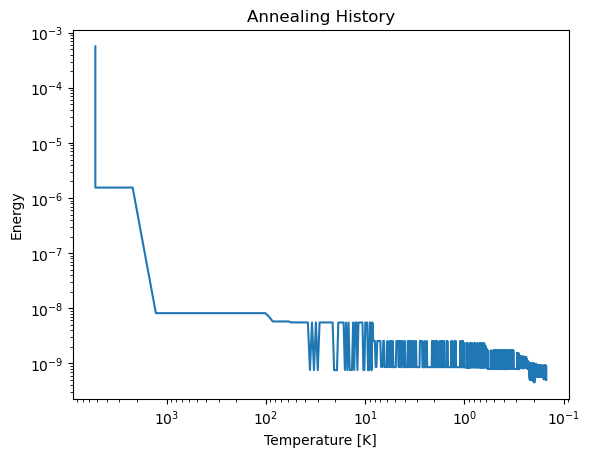

time: 474 ms (started: 2025-04-25 06:58:47 +08:00)


In [19]:
inversion.plot_annealing_hist()

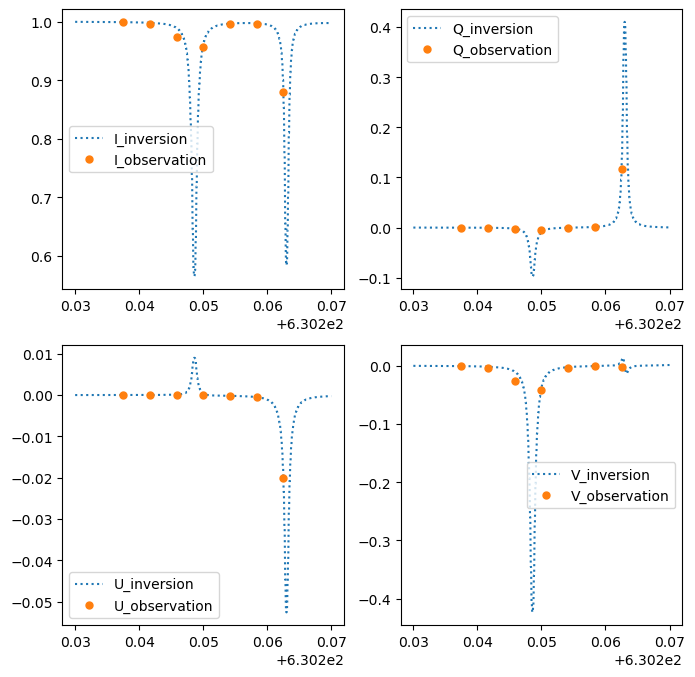

time: 218 ms (started: 2025-04-25 07:01:27 +08:00)


In [ ]:
# Plot the inversion results to check the consistence between the observation and the inversion
plt.figure(figsize=(8,8))
inversion.plot_inversion_results(choice_index=choice)
plt.show()

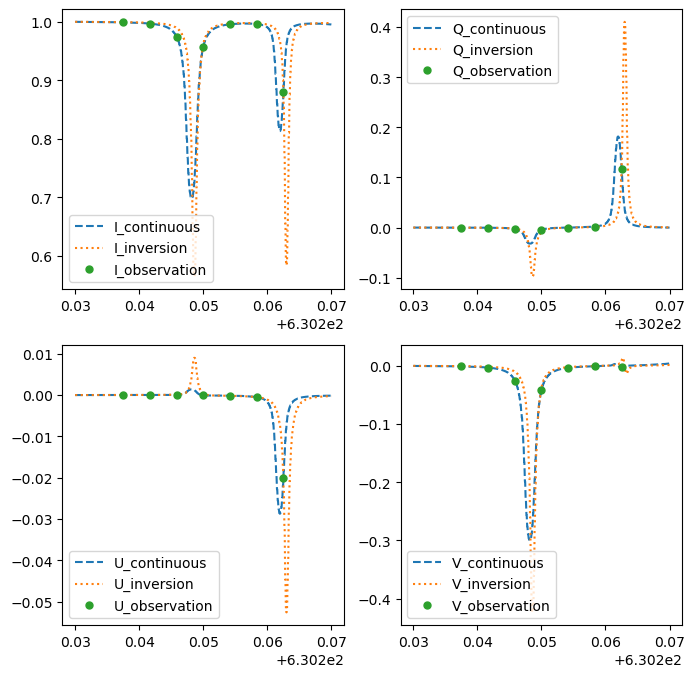

time: 240 ms (started: 2025-04-25 07:02:31 +08:00)


In [27]:
# When testing stage, we know the true parameters, so we can plot the inversion results to check the consistence between the observation and the inversion
plt.figure(figsize=(8,8))
inversion.plot_inversion_results(choice_index=choice, params_obs=params_obs)
plt.show()